# SNN with hierarchy of Time constant
---
This notebook is mainly for developing the code that will be rewritten in python files\\

The idea is to explore what role a hierarchy of time scales have in temporal processing, especially when dealing with multi-time-scale inputs.\\

Prior literature shows the importance of heterogeneity of time scales in SNNs, mainly showing that diversity of time-scales are beneficial.
- https://www.nature.com/articles/s41467-021-26022-3
- https://www.nature.com/articles/s41467-023-44614-z

However, an interpretation of the role of the hierarchy of time constant is still missing.

The assumption is that when treating a temporal sequence sempled at a certain period $\tau_{sampling}$ and with a total duration $\Tau$, there can be an optimal sequence of filters $F_i(\tau_i)$ that process the input sequence. For each of the filters $\tau_{i+1} > \tau_i$, where the subscript indicates the order of the filter. More simply, there is a hierarchy of time-scales - from fast to slow - that leads to an optimal processing of the input sequence.

In [15]:
import jax
import jax.numpy as jnp
from jax.example_libraries import optimizers

import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random

from jax import vmap, jit, value_and_grad, local_device_count
from jax.example_libraries import optimizers
from jax.lax import scan, cond
import pickle

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".25" # needed because network is huge
os.environ["CUDA_VISIBLE_DEVICES"]="0"
jax.devices()

[CpuDevice(id=0)]

# Hyperparameter sweep
---
performed with WandB

In [ ]:
import wandb
wandb.login()

## Parameters of the SNN model
---

In [3]:
from utils_initialization import SimArgs
args = SimArgs()

## Training function
---

In [4]:
from training import train_hsnn_wandb

# Sweep Configuration

In [5]:
sweep_config = {
    'method': 'grid',
}

metric = {
    'name': 'accuracy',
    'goal': 'maximize'
    }
sweep_config['metric'] = metric

config = {}
for i, [key, value] in enumerate( zip( args.__dict__.keys(), args.__dict__.values()  ) ):
    config[key] = {'value': value}
# update the parameters to sweep
config['tau_mem'] = {'values':[0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.8]}
config['seed'] = {'values':[0]}
config['n_epochs'] = {'value':5}
config['n_layers'] = {'value':4}

sweep_config['parameters'] = config

In [6]:
sweep_id = wandb.sweep(sweep_config, project="Tau_mem_short")

Create sweep with ID: qa0lo9cv
Sweep URL: https://wandb.ai/filomo14/Tau_mem_short/sweeps/qa0lo9cv


In [ ]:
wandb.agent(sweep_id, train_hsnn_wandb)

# Single Round
---
We'll use Leaky-Integrate-and-Fire neurons for the Hidden layers, Leaky-Integrator neurons for the output.

We also define some additional functions to: Introduce Noise in Weights and Membrane voltage, Introduce the Surrogate Gradient function.

In [2]:
from models import *
from utils_initialization import *
from training import *

In [13]:
args.train_alpha = False
args.hierarchy_tau = False
args.distrib_tau = 'uniform'
args.recurrent = False
args.normalizer = 'batch' # 'batch' #'layer'
args.n_layers = 4
# time constants
args.tau_mem = 0.1 #0.1
args.delta_tau = 0.075

# LR and regularizers
if args.recurrent: args.lr = 0.01
else: args.lr = 0.01
args.lr_decay = 0.5
args.lr_decay_every = 50
args.l2_lambda = 0 #1e-6
args.freq_lambda = 0 #1e-6
args.dropout_rate = 0.1
args.n_epochs = 10
args.decoder = 'cum'
args.dataset_name = 'shd'
args.n_out = 20 if args.dataset_name == 'shd' else 35  # output channels

# Training
train_loss, test_acc, val_acc, net_params_best = train_hsnn( args = args )

Train DL size: 6524, Validation DL size: 1632, Test DL size: 2264
Epoch: [1/10] - Loss: 1.41066 -  Training acc: 34.38 - Validation acc: 57.48 - t: 7.24 sec
Epoch: [2/10] - Loss: 0.93184 -  Training acc: 68.30 - Validation acc: 75.25 - t: 3.49 sec
Epoch: [3/10] - Loss: 0.51035 -  Training acc: 79.87 - Validation acc: 83.52 - t: 3.46 sec
Epoch: [4/10] - Loss: 0.45039 -  Training acc: 86.16 - Validation acc: 87.93 - t: 3.47 sec
Epoch: [5/10] - Loss: 0.36980 -  Training acc: 88.17 - Validation acc: 88.42 - t: 3.48 sec
Epoch: [6/10] - Loss: 0.29229 -  Training acc: 90.50 - Validation acc: 90.26 - t: 3.59 sec
Epoch: [7/10] - Loss: 0.40782 -  Training acc: 91.78 - Validation acc: 89.95 - t: 3.50 sec
Epoch: [8/10] - Loss: 0.25025 -  Training acc: 93.62 - Validation acc: 90.62 - t: 3.51 sec
Epoch: [9/10] - Loss: 0.16908 -  Training acc: 94.13 - Validation acc: 93.14 - t: 3.52 sec
Epoch: [10/10] - Loss: 0.18330 -  Training acc: 95.05 - Validation acc: 92.77 - t: 3.52 sec
Validation Accuracy: 93

0.7431348
0.85944736


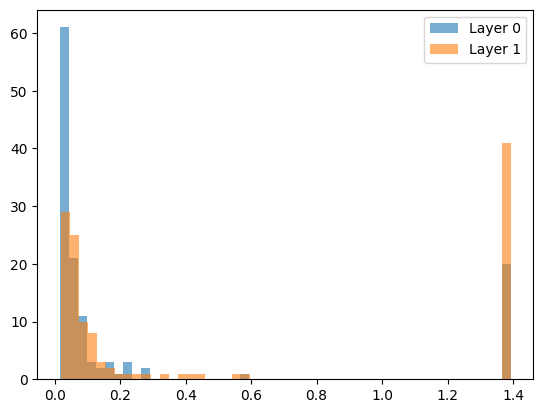

In [12]:
import matplotlib.pyplot as plt
for i in range(args.n_layers-1):
    # _ = plt.hist( net_params_best[i][1], 25, alpha=0.6, label=f'Layer {i}' )
    _ = plt.hist( - args.timestep / np.log( np.clip( net_params_best[i][1], 1e-8, 1-1e-2 ) ), 50, alpha=0.6, label=f'Layer {i}' )
    print( np.mean(  net_params_best[i][1] ) )
plt.legend()

# HSNN analysis (Figure 2)
---
Here we take a pre-trained hSNN model and analyze its performance, trying to understand "how" and "why" it performs well.

In [309]:
# Import model
import pickle, os
dir_models = '/Users/filippomoro/Documents/hsnn/results'
model_path = 'Hierarchy_tau_mem100_delta_tau90_seed0'
model_name = os.path.join( model_path, 'model.pkl' )
file_name = os.path.join( dir_models, model_name ) 
loaded_model = pickle.load( open( file_name, 'rb' ) )
args = loaded_model['args']
net_params_best = loaded_model['net_params_best']

In [313]:
loaded_model['val_acc']

Array(97.05882, dtype=float32)

In [12]:
# Load the test set of the dataset
from utils_dataset import get_dataloader
_, _, test_dl = get_dataloader( args=args, verbose=True )

Train DL size: 8156, Validation DL size: 1632, Test DL size: 2264


In [13]:
from utils_initialization import params_initializer, SimArgs
from utils_normalization import LayerNorm, BatchNorm
from models import lif_step, rlif_step, li_step, dropout
from models import decoder_cum, decoder_freq, decoder_sum, decoder_vlast, decoder_vmax

# selecting the right decoder
decoder_dict = {'cum'  : decoder_cum,
                'sum'  : decoder_sum,
                'vmax' : decoder_vmax,
                'vlast': decoder_vlast,
                'freq' : decoder_freq
                }
if args.decoder in decoder_dict.keys():
    decoder = decoder_dict[args.decoder]
else: 
    print('Unrecognized Decoder, will revert to a "cum"-style decoder')
    print('Next time choose a decoder in: '+str(list(decoder_dict.keys())))
    args.decoder = 'cum'
    decoder = decoder_dict[args.decoder]

# network architecture
if args.recurrent:
    layer = rlif_step
else: 
    layer = lif_step
if args.decoder == 'freq':
    layer_out = lif_step
else: 
    layer_out = li_step
if args.normalizer == 'batch': norm = BatchNorm
elif args.normalizer == 'layer': norm = LayerNorm
else: norm = None

In [24]:
from jax import jit, vmap

@jit
def scan_layer( args_in, input_spikes ):
    args_out_layer, out_spikes_layer = scan( layer, args_in, input_spikes, length=args.nb_steps )
    return args_out_layer, out_spikes_layer
vscan_layer = vmap( scan_layer, in_axes=(None, 0))

@jit
def scan_out_layer( args_in, input_spikes ):
    args_out_layer, out_spikes_layer = scan( layer_out, args_in, input_spikes, length=args.nb_steps )
    return args_out_layer, out_spikes_layer
vscan_layer_out = vmap( scan_out_layer, in_axes=(None, 0))

# the following function implements the main network
@jit
def hsnn( args_in, input_spikes ):
    net_params, net_states, key, dropout_rate = args_in # input arguments
    n_layers = len( net_params )                        # umber of layers
    # collection of output spikes
    out_spike_net = [] # collects the spikes from each layer
    # Loop over the layers
    for l in range(n_layers):
        # selecting the right input (from the previous layer)
        if l == 0: layer_input_spike = input_spikes
        else: layer_input_spike = out_spikes_layer
        # making layers' params and states explitic
        # parameters (weights and alpha) and the state of the neurons (spikes, inputs and membrane, ecc..)
        w, alpha = net_params[l]; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states[l]
        if len(w) == 3: # it means that we'll do normalization
            weight, scale, bias = w
        else: weight = w
        if len(weight) ==2: weight, _ = weight
        # Multiplying the weights by the spikes
        I_in = jnp.matmul(layer_input_spike, weight)
        # Normalization (if selected)
        if len(w) == 3: # it means that we'll do normalization
            b, t, n = I_in.shape
            I_in = norm( I_in.reshape( b*t, n ), bias = bias, scale = scale )
            I_in = I_in.reshape( b,t,n ) # normalized input current
        # Forward pass of the Layer
        args_in_layer = [net_params[l], net_states[l]]
        if l+1 == n_layers:
            _, out_spikes_layer = vscan_layer_out( args_in_layer, I_in )
        else: 
            _, out_spikes_layer = vscan_layer( args_in_layer, I_in )
            # Dropout
            key, key_dropout = jax.random.split(key, 2)
            out_spikes_layer = dropout( key_dropout, out_spikes_layer, rate=dropout_rate, deterministic=False )
        out_spike_net.append(out_spikes_layer)
    return out_spikes_layer, out_spike_net

def one_hot(x, n_class):
    return jnp.array(x[:, None] == jnp.arange(n_class), dtype=jnp.float32)

### Perform inference with the Test set and check the spiking-activity of the network

In [186]:
def run_inference( loaded_model ):
    args = loaded_model['args']
    net_params_best = loaded_model['net_params_best']

    # Initialize states
    _ , net_states = params_initializer(key=jax.random.PRNGKey(args.seed), args=args)

    # Take a new batch
    x_test, y_test = next(iter( test_dl ))

    # Inference
    dropout_rate = 0.
    key=jax.random.PRNGKey(args.seed)
    args_in = [net_params_best, net_states, key, dropout_rate]
    output_layer, out_spike_net = hsnn( args_in, x_test ) # ------------> OUT_SPIKE_NET is what we're after
    Yhat = decoder( output_layer )
    # compute the loss and correct examples
    Y_test = one_hot( y_test, 20 )
    num_correct = jnp.sum(jnp.equal(jnp.argmax(Yhat, 1), jnp.argmax(Y_test, 1)))
    # cross entropy loss
    loss_ce = -jnp.mean( jnp.sum(Y_test * jnp.log(Yhat+1e-12), axis=-1) )
    # L2 norm
    loss_l2 = optimizers.l2_norm( [net_params_best[l][0] for l in range(len(net_params_best))] ) * args.l2_lambda
    # firing rate loss
    avg_spikes_neuron = jnp.mean( jnp.stack( [ jnp.mean( jnp.sum( out_spike_net[l], axis=1 ), axis=(0,-1) ) for l in range( len(net_params_best)-1 )] ) )
    loss_fr = args.freq_lambda * (args.target_fr - avg_spikes_neuron)**2
    # Total loss
    loss_total = loss_ce + loss_l2 + loss_fr
    loss_values = [num_correct, loss_ce]
    return out_spike_net

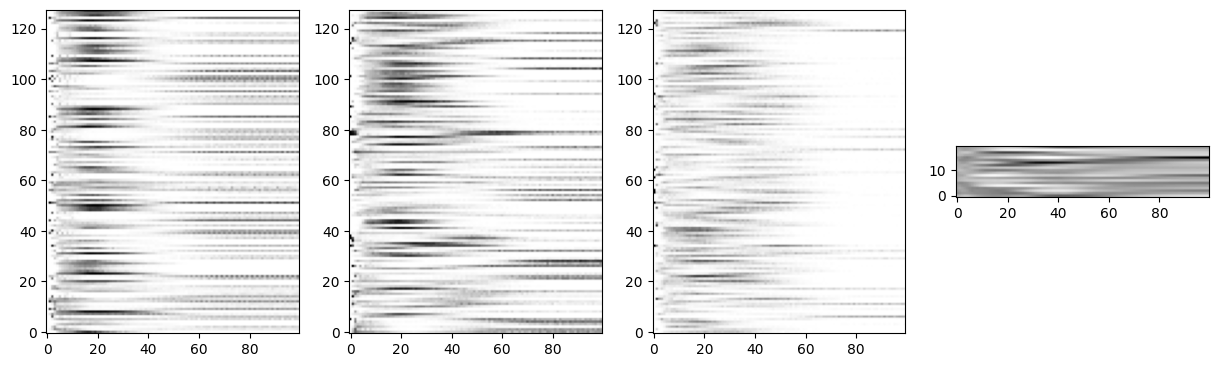

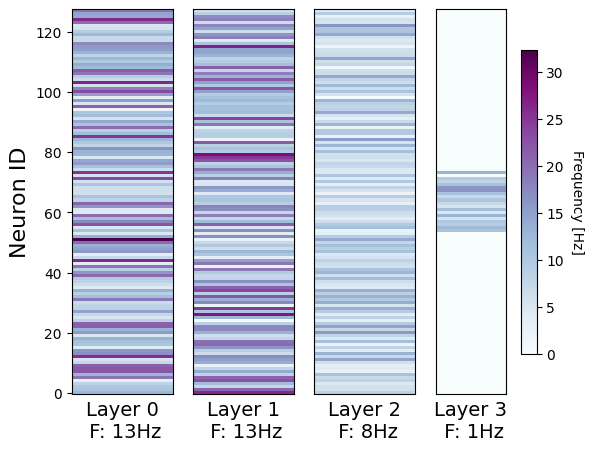

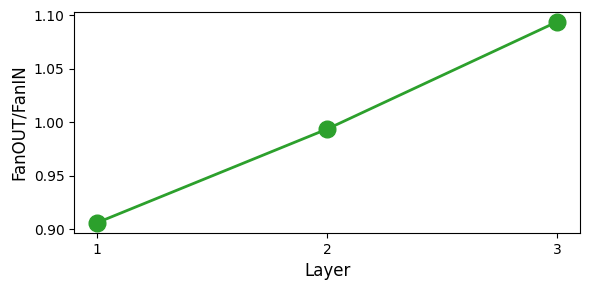

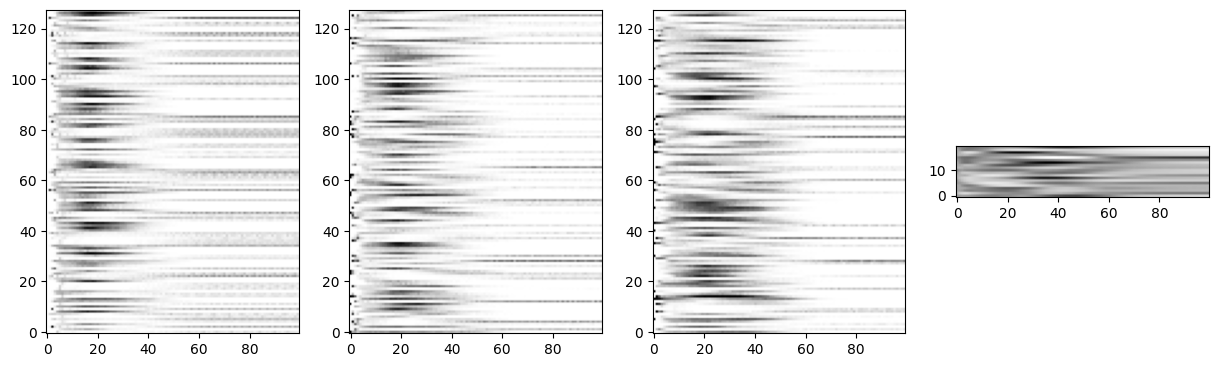

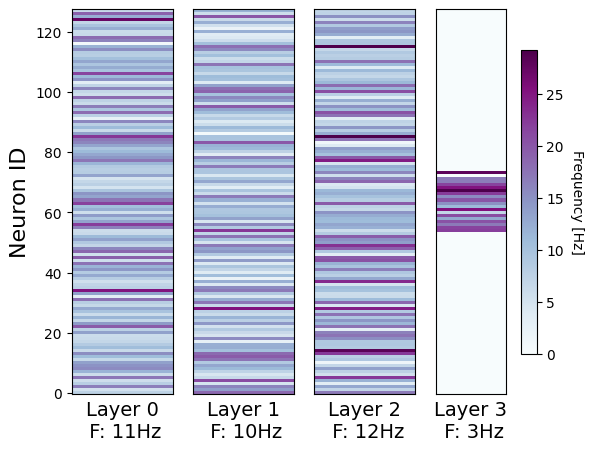

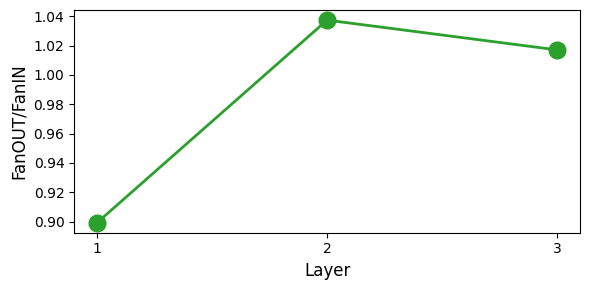

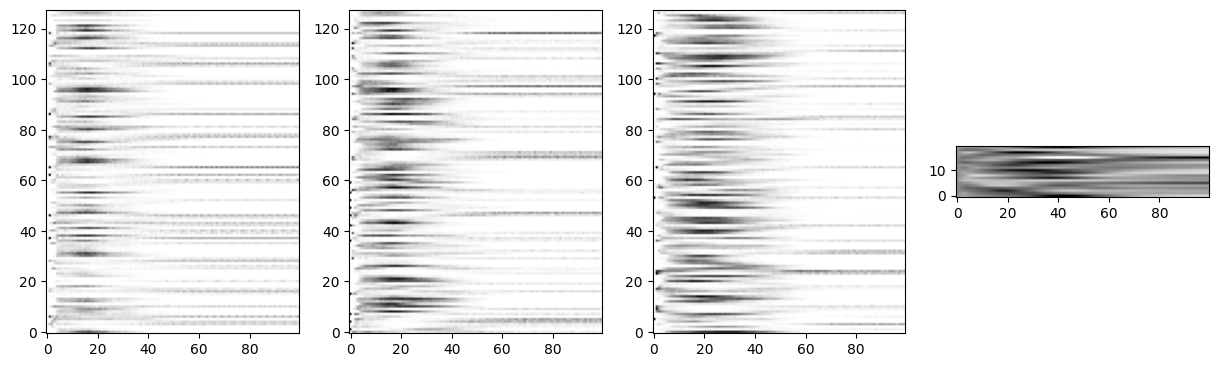

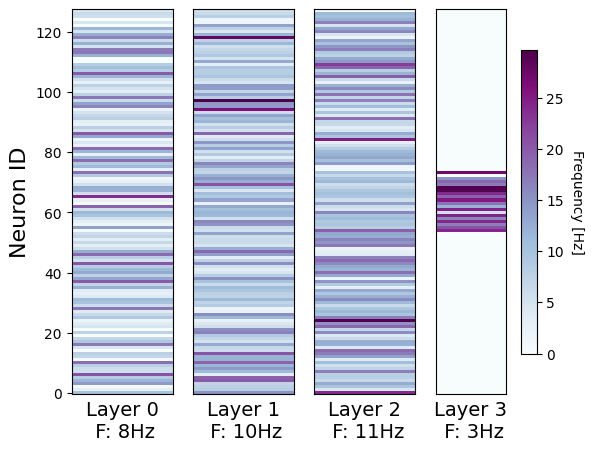

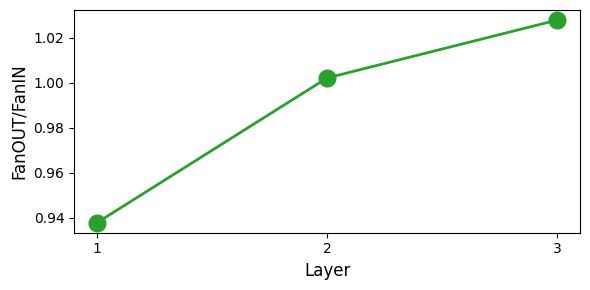

In [251]:
model_paths = ['Hierarchy_tau_mem100_delta_tau-90_seed0', 
               'Hierarchy_tau_mem100_delta_tau0_seed0', 
               'Hierarchy_tau_mem100_delta_tau90_seed0']
spiking_activity_models = []

for m, model_path in enumerate( model_paths ):
    model_name = os.path.join( model_path, 'model.pkl' )
    file_name = os.path.join( dir_models, model_name )
    loaded_model = pickle.load( open( file_name, 'rb' ) )
    out_spike_net = run_inference( loaded_model )

    # Computing Fan-in Fan-out
    FanIN, FanOUT = [], []
    for i in range( args.n_layers-1 ):
        FanIN.append( np.abs( loaded_model['net_params_best'][i][0][0] ).mean(0) )
        FanOUT.append( np.abs( loaded_model['net_params_best'][i+1][0][0] ).mean(1) )
    FanIN = np.array( FanIN ); FanOUT = np.array( FanOUT )

    # collecting the spiking activity
    spiking_activity = []
    for i in range( args.n_layers ):
        # print( f'Layer {i+1}, spiking frequency: {out_spike_net[i].mean()*args.timestep**-1:.2f}Hz' )
        if i == args.n_layers-1:
            mean_spk = 0. #out_spike_net[0].mean( ).reshape(-1,1) *args.timestep**-1
            padded_spikes = np.pad( out_spike_net[i].mean( axis=(0,1) ) + np.abs( out_spike_net[i].mean( axis=(0,1) ).min() ), 
                                pad_width=( int( (args.n_hid-20)/2) ), constant_values=(mean_spk) ).reshape(-1,1)
            padded_spikes = ( padded_spikes / padded_spikes.max() ) * spiking_activity[-1].max()
            spiking_activity.append( padded_spikes )
        else:
            spiking_activity.append( out_spike_net[i].mean( axis=(0,1) ).reshape(-1,1) *args.timestep**-1 )
    spiking_activity = np.hstack( spiking_activity ).T
    spiking_activity_models.append(spiking_activity)

    # Plotting the spiking activity
    fig, ax = plt.subplots( 1, args.n_layers, figsize=( 15,10 ) )
    fig2, ax2 = plt.subplots( 1, args.n_layers, figsize=( 6,5 ) )
    for i in range( args.n_layers ):
        ax[i].imshow( out_spike_net[i].mean( axis=(0) ).T, cmap='Grays', origin='lower' )
        im = ax2[i].imshow( spiking_activity[i].reshape(-1,1), aspect='auto', cmap='BuPu',
                            vmin=0, vmax=spiking_activity.flatten().max(), origin='lower' )
        ax2[i].set_xticks( [] ); ax2[i].set_xlabel(f'Layer {i}\n F: {spiking_activity[i].mean():.0f}Hz', size=14)
        if i != 0: ax2[i].set_yticks([])
        else: ax2[i].set_ylabel( 'Neuron ID', size=16 )
    cbar = fig.colorbar(im, ax=ax2[i], pad=0.15)
    cbar.ax.set_ylabel('Frequency [Hz]', rotation=-90, va="bottom")

    # Plotting the FanIN/FanOUT
    figF, axF = plt.subplots( figsize=(6,3) )
    axF.plot( np.mean(FanOUT/FanIN, axis=1), color='tab:green', marker='o', ms=12, lw=2 )
    axF.set_xticks( np.arange( args.n_layers-1 ), np.arange( args.n_layers-1 )+1 )
    axF.set_ylabel( 'FanOUT/FanIN', size=12 )
    axF.set_xlabel( 'Layer', size=12 )
    
    plt.tight_layout()
    plt.show()

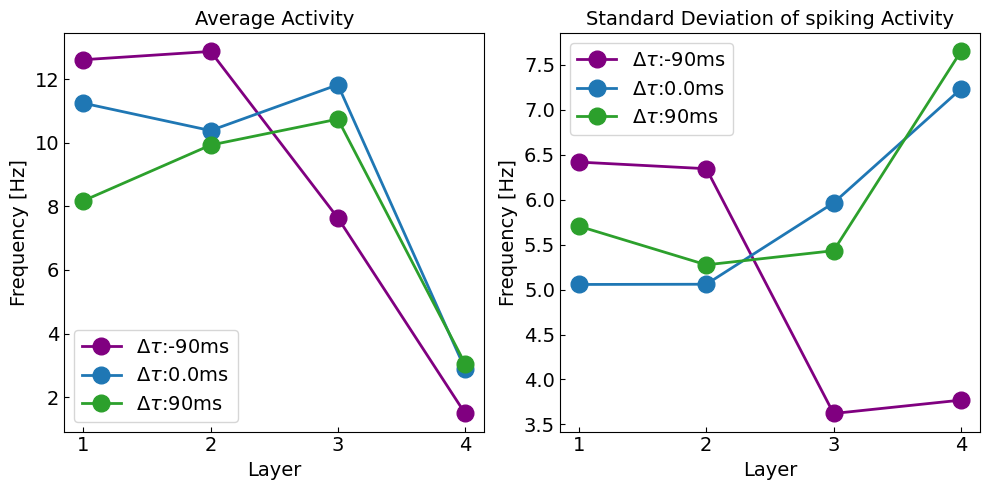

In [211]:
fig_freq, ax = plt.subplots( 1,2, figsize=(10,5) )
# plotting the aerage frequency per layer, for the different models
deltas = [-90, 0., 90]
colors  = ['purple', 'tab:blue', 'tab:green']
for s, spiking_activity in enumerate( spiking_activity_models ):
    ax[0].plot( [spiking_activity[i].mean() for i in range(args.n_layers)], 
                color=colors[s], label=r'$\Delta \tau$:'+str(deltas[s])+'ms',
                marker='o', ms=12, lw=2 )
    ax[1].plot( [spiking_activity[i].std() for i in range(args.n_layers)], 
                color=colors[s], label=r'$\Delta \tau$:'+str(deltas[s])+'ms',
                marker='o', ms=12, lw=2 )
[ax[i].set_xticks( np.arange( args.n_layers ), np.arange( args.n_layers )+1 ) for i in range(len(ax))]
[ax[i].set_xlabel( 'Layer', size=14 ) for i in range(len(ax))]
[ax[i].set_ylabel( 'Frequency [Hz]', size=14 ) for i in range(len(ax))]
[ax[i].legend(prop={'size':14}) for i in range(len(ax))]
[ax[i].tick_params( labelsize=14, direction='in' ) for i in range(len(ax))]
ax[0].set_title( 'Average Activity', size=14 )
ax[1].set_title( 'Standard Deviation of spiking Activity', size=14 )
plt.tight_layout()

- time constant hierarchy emerging from training

In [16]:
from utils_initialization import *
from training import *

In [17]:
# Hyperparameter setting
args.train_alpha = True
args.hierarchy_tau = False
args.distrib_tau = 'normal'
args.recurrent = True
args.n_layers = 4
# time constants
args.tau_mem = 0.05
args.delta_tau = 0.075
args.distrib_tau_sd = 0.0
# LR and regularizers
args.n_epochs = 10
args.dataset_name = 'shd'
args.decoder = 'cum'
args.n_out = 20 if args.dataset_name == 'shd' else 35  # output channels
args.verbose = False


# pick 5 seeds and store the initial time constant
seeds = [0,1,2,3,4]

time_const_init_list, time_const_train_list = [], []
test_accs = []
for s in seeds:
    print('-- Seed '+str(s))
    args.seed = s
    key = jax.random.PRNGKey(args.seed)
    net_params, _ = params_initializer( key=key, args=args )
    time_const_init_list.append( [net_params[i][1] for i in range(len(net_params)-1)] )

    # Training and collecting the time constants
    train_loss, test_acc, val_acc, net_params_train = train_hsnn( args = args )
    test_accs.append( test_acc )
    time_const_train_list.append( [net_params_train[i][1] for i in range(len(net_params_train)-1)] )

import pickle
dict_tau_F2 = {
    'args' : args, 'seeds' : seeds, 
    'time_const_init_list' :time_const_init_list, 
    'time_const_train_list' : time_const_train_list,
    'test_accs' : test_accs,
}
file_save_tau_F2 = './results/F2/Tau_analysis_1604_rec.pkl'
pickle.dump( dict_tau_F2, open( file_save_tau_F2, 'wb' ) )

-- Seed 0
Train DL size: 6524, Validation DL size: 1632, Test DL size: 2264
Validation Accuracy: 94.79
Test Accuracy: 84.94
-- Seed 1
Train DL size: 6524, Validation DL size: 1632, Test DL size: 2264
Validation Accuracy: 94.24
Test Accuracy: 85.56
-- Seed 2
Train DL size: 6524, Validation DL size: 1632, Test DL size: 2264
Validation Accuracy: 91.85
Test Accuracy: 82.91
-- Seed 3
Train DL size: 6524, Validation DL size: 1632, Test DL size: 2264
Validation Accuracy: 93.26
Test Accuracy: 79.99
-- Seed 4
Train DL size: 6524, Validation DL size: 1632, Test DL size: 2264
Validation Accuracy: 95.22
Test Accuracy: 85.03


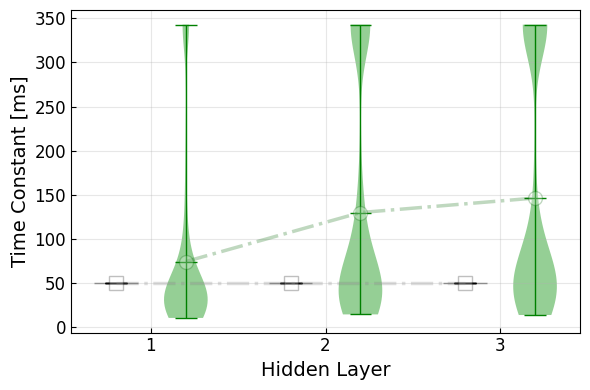

In [29]:
# import the data
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
file_save_tau_F2 = './results/F2/Tau_analysis_1604.pkl'
dict_tau_F2 = pickle.load( open(file_save_tau_F2, 'rb' ) )
args = dict_tau_F2['args']; seeds = dict_tau_F2['seeds']
time_const_init_list = dict_tau_F2['time_const_init_list']
time_const_train_list = dict_tau_F2['time_const_train_list']
test_accs = dict_tau_F2['test_accs' ]

fig, ax = plt.subplots( figsize=(6,4) )

# Initialized taus
ds_init  = np.clip( np.hstack( time_const_init_list ), 0, 1.0-4e-2)
ds_init  = - 1e3 * args.timestep / np.log( ds_init )
violin_init = ax.violinplot( list(ds_init), positions=np.arange( args.n_layers-1 )-0.2,
                    widths=0.25, showmeans=True )
_ = ax.plot( np.arange( args.n_layers-1 )-0.2, ds_init.mean( axis=-1 ),
            color='gray', marker = 's', markeredgecolor='k', ls='-.',
            markerfacecolor='white', lw=2.5, alpha=0.25, ms=10 )

for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = violin_init[partname]; vp.set_edgecolor('k');vp.set_linewidth(1)
for pc in violin_init['bodies']:
    pc.set_facecolor('gray');pc.set_edgecolor('black');pc.set_alpha(0.5)

# Optimized taus
ds_train = np.clip( np.hstack( time_const_train_list ), 0, 1.0-4e-2)
ds_train = - 1e3 * args.timestep / np.log( ds_train )
violin_train = ax.violinplot( list(ds_train), positions=np.arange( args.n_layers-1 )+0.2,
                    widths=0.25, showmeans=True, showextrema=True )
_ = ax.plot( np.arange( args.n_layers-1 )+0.2, np.mean(ds_train, axis=-1 ),
            color='darkgreen', marker = 'o', markeredgecolor='darkgreen', ls='-.',
            markerfacecolor='white', lw=2.5, alpha=0.25, ms=10 )
# ax.set_yscale('log')
ax.set_xlabel( 'Hidden Layer', size=14 )
ax.set_ylabel( 'Time Constant [ms]', size=14 )
ax.tick_params( direction='in', labelsize=12 )
ax.set_xticks( np.arange( args.n_layers-1 ), np.arange( args.n_layers-1 )+1 )
# ax.legend(prop={'size':14})
ax.grid(alpha=0.3)

for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = violin_train[partname];vp.set_edgecolor('green');vp.set_linewidth(1)
for pc in violin_train['bodies']:
    pc.set_facecolor('tab:green');pc.set_alpha(0.5)

plt.tight_layout()
file_save_F2_tau = f'./results/F2/Tau_analysis_{args.n_layers}.pdf'
# fig.savefig( file_save_F2_tau, dpi = 300, transparent=False )

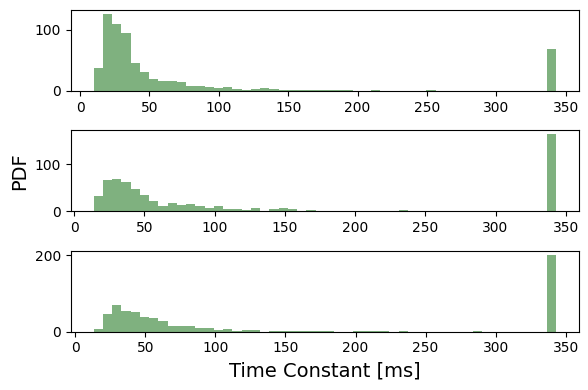

In [31]:
# import the data
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
file_save_tau_F2 = './results/F2/Tau_analysis_1604.pkl'
dict_tau_F2 = pickle.load( open(file_save_tau_F2, 'rb' ) )
args = dict_tau_F2['args']; seeds = dict_tau_F2['seeds']
time_const_init_list = dict_tau_F2['time_const_init_list']
time_const_train_list = dict_tau_F2['time_const_train_list']
test_accs = dict_tau_F2['test_accs' ]


# Initialized taus
ds_init  = np.clip( np.hstack( time_const_init_list ), 0, 1.0-4e-2)
ds_init  = - 1e3 * args.timestep / np.log( ds_init )

fig, ax = plt.subplots( ds_init.shape[0],1, figsize=(6,4) )
# for i in range(ds_init.shape[0]):
#     _ = ax[i].hist( ds_init[i], 50, color='k', density=True, alpha=1 )

# Optimized taus
ds_train = np.clip( np.hstack( time_const_train_list ), 0, 1.0-4e-2)
ds_train = - 1e3 * args.timestep / np.log( ds_train )
for i in range(ds_init.shape[0]):
    _ = ax[i].hist( ds_train[i], 50, color='darkgreen', density=False, alpha=0.5 )
    # _ = ax[0].hist( ds_train[i], 50, density=False, alpha=0.5 )

# ax.set_yscale('log')
ax[1].set_ylabel( 'PDF', size=14 )
ax[-1].set_xlabel( 'Time Constant [ms]', size=14 )
# ax[-1].tick_params( direction='in', labelsize=12 )
# [ ax[i].set_xticks( np.arange( args.n_layers-1 ), np.arange( args.n_layers-1 )+1 )
#  for i in range(ds_init.shape[0]) ]
# ax.legend(prop={'size':14})
# ax.grid(alpha=0.3)

plt.tight_layout()
file_save_F2_tau = f'./results/F2/Tau_analysis_{args.n_layers}_PDF.pdf'
# fig.savefig( file_save_F2_tau, dpi = 300, transparent=False )

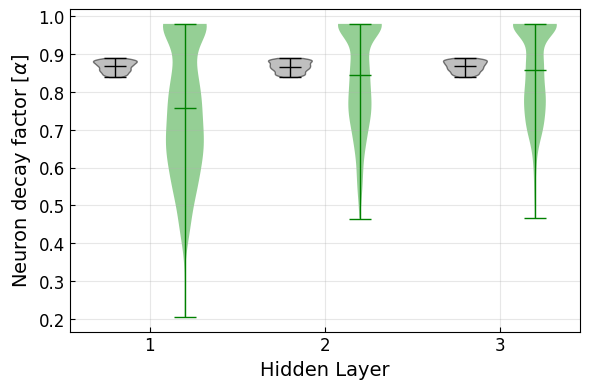

In [17]:
fig, ax = plt.subplots( figsize=(6,4) )

# Initialized taus
ds_init  = np.clip( np.hstack( time_const_init_list ), 0, 1.0-2e-2)
# ds_init  = - 1e3 * args.timestep / np.log( ds_init )
violin_init = ax.violinplot( list(ds_init), positions=np.arange( args.n_layers-1 )-0.2,
                    widths=0.25, showmeans=True )

for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = violin_init[partname]; vp.set_edgecolor('k');vp.set_linewidth(1)

for pc in violin_init['bodies']:
    pc.set_facecolor('gray');pc.set_edgecolor('black');pc.set_alpha(0.5)

# Optimized taus
ds_train = np.clip( np.hstack( time_const_train_list ), 0, 1.0-2e-2)
# ds_train = - 1e3 * args.timestep / np.log( ds_train )
violin_train = ax.violinplot( list(ds_train), positions=np.arange( args.n_layers-1 )+0.2,
                    widths=0.25, showmeans=True, showextrema=True )
# ax.set_yscale('log')
ax.set_xlabel( 'Hidden Layer', size=14 )
ax.set_ylabel( r'Neuron decay factor [$\alpha$]', size=14 )
ax.tick_params( direction='in', labelsize=12 )
ax.set_xticks( np.arange( args.n_layers-1 ), np.arange( args.n_layers-1 )+1 )
# ax.legend(prop={'size':14})
ax.grid(alpha=0.3)

for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = violin_train[partname];vp.set_edgecolor('green');vp.set_linewidth(1)

for pc in violin_train['bodies']:
    pc.set_facecolor('tab:green');pc.set_alpha(0.5)

plt.tight_layout()